### This is a small EV flexibility tutorial of an example that i used the most functions my tool with a detail print of each task. ###

In [27]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

In [28]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############3
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# %run ../Data/Electric_Network/7-Bus-Test-System.ipynb
net = pn.simple_four_bus_system()
net.bus['max_vm_pu'] = 1.05
net.bus['min_vm_pu'] = 0.95
# net.ext_grid['Smax'] = 0.315/net.sn_mva

#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index

# print(Y_bus_df)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

### Generate enviromen data
file_path2 = '../Data/profiles/Enviroment_profiles/dataset2.xlsx'
enviroment_data = pd.read_excel(file_path2, index_col='Time')
enviroment_data=enviroment_data.iloc[0:96,:]

print(Y_bus_df)
print(profiles.head())
print(enviroment_data.head())

                    0                   1                   2  \
0  1.875150-5.962120j -1.357392-6.100772j  0.000000+0.000000j   
1  4.604728-4.225922j  2.365398-6.025498j -0.490248+0.063381j   
2  0.000000+0.000000j -0.490248+0.063381j  0.980497-0.126757j   
3  0.000000+0.000000j  0.000000+0.000000j -0.490248+0.063381j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2 -0.490248+0.063381j  
3  0.490248-0.063378j  
       Time  PV_Systems  PV_Rooftop  Load_Profile
0  00:00:00    0.000015    0.000015      0.122509
1  00:30:00    0.000015    0.000015      0.118885
2  01:00:00    0.000015    0.000015      0.116586
3  01:30:00    0.000016    0.000016      0.114244
4  02:00:00    0.000016    0.000016      0.111212
                      Tout  SolGlob
Time                               
2019-02-21T18:30:00Z   0.1        0
2019-02-21T19:00:00Z   0.2        0
2019-02-21T19:30:00Z   0.3        0
2019-02-21T20:00:00Z   0.3        0
2019-02-21T20:30:00Z   0.3        0


In [30]:
############## Initialize model ######################
# model = ConcreteModel() # Create the pyomo model
# import suffixes (marginal values) -- "import them from the solver"
# model.dual = Suffix(direction=Suffix.IMPORT) #This save the dual variables and give us information about how the constrains affect the solution
sys.path.append('../ADN_OPF/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)

# During the Manager call there was pyomo creation model and several other initializations that automatically transfer the pandapower
# probelm into a dataframe for easily access on them after.
# The major procedure was made in AdditionalData Class which is located for now and then in .anc_Vars.

print(manager.net) # This is the pandapower details it was extremely important since most of the parameters are based on this
print(f"f={manager.anc_Vars.f:.4f}, S_Base={manager.anc_Vars.S_Base:.4f}, V_Base={manager.anc_Vars.V_Base:.4f}, Z_base={manager.anc_Vars.Z_base:.4f}, I_base={manager.anc_Vars.I_base:.4f}")
###### Everything was in p.u. ######
print(manager.anc_Vars.System_Data_Nodes, "\n", manager.anc_Vars.System_Data_Lines, "\n", manager.anc_Vars.System_Data_DER, "\n", "\n", manager.anc_Vars.System_Data_Grid, "\n", manager.anc_Vars.system_data_load)
##### If some of the DER is controllable you have to defined it manually since pandapower does not have this function. #####
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True

# Currently the following lists is empty however during the run you can access and see the available set,variables, 
# parameters and constraints through this code.
print(manager.list_variables())
print(manager.list_parameters())
print(manager.list_constraints())
print(manager.list_sets())


This pandapower network includes the following parameter tables:
   - bus (4 elements)
   - load (2 elements)
   - sgen (2 elements)
   - ext_grid (1 element)
   - line (2 elements)
   - trafo (1 element)
   - bus_geodata (4 elements)
 and the following results tables:
   - res_bus (4 elements)
   - res_line (2 elements)
   - res_trafo (1 element)
   - res_ext_grid (1 element)
   - res_load (2 elements)
   - res_sgen (2 elements)
f=50.0000, S_Base=1.0000, V_Base=0.4000, Z_base=0.1600, I_base=1.4434
   Nodes  min_v  max_v     name Feeder
0      0   0.95   1.05  bus1ref   None
1      1   0.95   1.05     bus2   None
2      2   0.95   1.05     bus3   None
3      3   0.95   1.05     bus4   None 
    FROM  TO  vn_kv  V_base [kV]  Z_base [Ohm]        R         X         Y  \
0     1   2    0.4          0.4          0.16  2.00625  0.259375  0.000005   
1     2   3    0.4          0.4          0.16  2.00625  0.259375  0.000005   

      Imax  
0  0.09838  
1  0.09838   
    DER_node  P_min  P_m

In [31]:
manager.anc_Vars.addEV(node=2,P_min_ch=0,P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=0.95, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[10,10+48],distance=[20,20])
manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=0.95, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
manager.anc_Vars.addFlexBuilding(node=2, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")
manager.anc_Vars.addFlexBuilding(node=3, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")

print(manager.anc_Vars.system_data_ev)
print(manager.anc_Vars.system_data_ev_char)
print(manager.anc_Vars.system_data_hp)

   EV_node  EV_Pmin_ch  EV_Pmax_ch   EV_Qmin   EV_Qmax     P_control  \
0        2         0.0       0.011 -0.003616  0.003616  controllable   
1        3         0.0       0.011 -0.003616  0.003616  controllable   

      Q_control  EV_costh    V2G  EV_EC  EV_SOC_ini  EV_SOC_end  EV_SOC_min  \
0  controllable      0.95  False  0.056          30         100          30   
1  controllable      0.95  False  0.056          55         100          25   

   EV_SOC_max  Consumption(MWh)_per_100km  
0          80                       0.017  
1          80                       0.016  
   EV_node departure   arrival  distance trip_energy_needs  \
0        2  [10, 58]  [36, 84]  [20, 20]  [0.0034, 0.0034]   
1        3  [14, 62]  [33, 81]  [50, 50]    [0.008, 0.008]   

  SoC_Needs_For_Trip(%) Min_SOC_Before_Departure(%)  
0      [6.0714, 6.0714]          [36.0714, 36.0714]  
1    [14.2857, 14.2857]          [39.2857, 39.2857]  
   HP_node  P_min  P_max                                      RC

In [32]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
manager.show_set("Sbuses")
manager.show_set("SGenbuses")
manager.show_set("SGrid")
manager.show_set("SDER_contr")
manager.show_set("SDER_uncontr")
manager.show_set("SLoadbuses")
manager.show_set("Slines")
manager.show_set("STimes")
manager.show_set("SEVbuses")
manager.show_set("SDistance_ind")
manager.show_set("SHPbuses")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STransformers', 'STimes', 'SEVbuses', 'SDistance_ind', 'SHPbuses', 'Sdownstream', 'Supstream', 'Sdownstream_transformer', 'Supstream_transformer', 'Sreverse_lines', 'Sreverse_transformers']
Set Sbuses: [0, 1, 2, 3]
Set 'SGenbuses' does not exist.
Set SGrid: [0]
Set SDER_contr: [2]
Set SDER_uncontr: [3]
Set SLoadbuses: [2, 3]
Set Slines: [(1, 2), (2, 3)]
Set STimes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Set SEVbuses: [2, 3]
Set SDistance_ind: [0, 1]
Set SHPbuses: [2, 3]


In [33]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles=profiles, load_p_name_prefix="Load_P", load_q_name_prefix="Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df=Y_bus_df, resist_prefix="resistance_Parm", react_prefix="reactance_Parm", adm_real_prefix="admitt_mat_Parm_real", adm_img_prefix="admitt_mat_Parm_imag")

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

############ HP #################
manager.initialize_hp_params("min_HP_power", "max_HP_power", "min_temp_preference_param", "max_temp_preference_param")
manager.enviroment_profile_param(enviroment_data, "Tout_param", "Qsolar_param")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q', 'min_HP_power', 'max_HP_power', 'min_temp_preference_param', 'max_temp_preference_param', 'Tout_param', 'Qsolar_param']
Variable Load_P:
  (2, 0): 0.0036752644392
  (2, 1): 0.00356655123
  (2, 2): 0.0034975863051
  (2, 3): 0.0034273171508999996
  (2, 4): 0.003336370929
  (2, 5): 0.0031993126830000005
  (2, 6): 0.0030531054132
  (2, 7): 0.0029361103880999996
  (2, 8): 0.0027957841179
  (2, 9): 0.0026178374244
  (2, 10): 0.0026060933921999998
  (2, 11): 0.0024847220564999995
  (2, 12): 0.0024768300

In [34]:
manager.parameter_df.wrapper_parameter_df()
print(manager.parameter_df.list())
print(manager.parameter_df.EV_SoC_max_param.head())

['EV_SoC_max_param', 'EV_SoC_min_departure_param', 'EV_SoC_min_overtime_param', 'EV_SoC_min_param', 'EV_available_param', 'EV_capacity_param', 'EV_trip_energy_needs_param', 'EVend_SOC_param', 'EVinit_SOC', 'Load_P', 'Load_Q', 'Qsolar_param', 'Tout_param', 'admitt_mat_Parm_imag', 'admitt_mat_Parm_real', 'ctrl_PV_gen_P', 'ctrl_PV_gen_Q', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_max_ch_param', 'ev_min_ch_param', 'ev_trip_distance_param', 'max_HP_power', 'max_temp_preference_param', 'min_HP_power', 'min_temp_preference_param', 'reactance_Parm', 'resistance_Parm', 'unctrl_PV_gen_P', 'unctrl_PV_gen_Q']
        Value
Index        
0      0.0448
1      0.0448


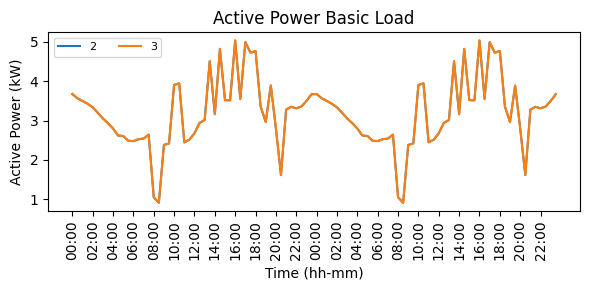

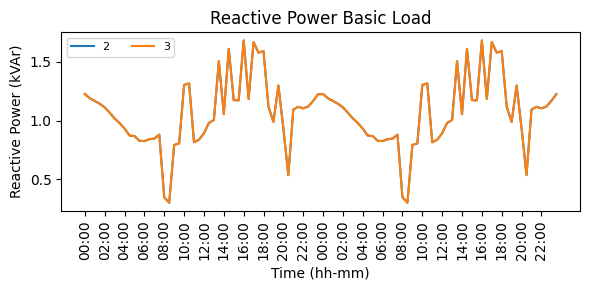

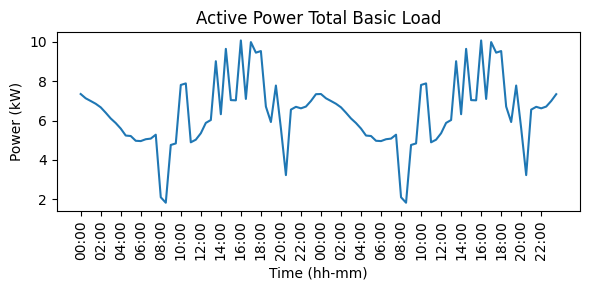

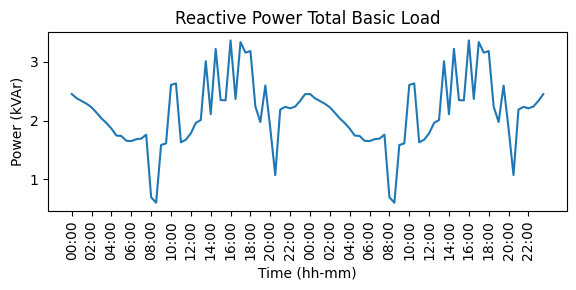

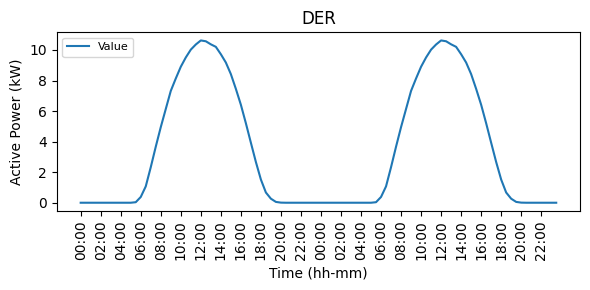

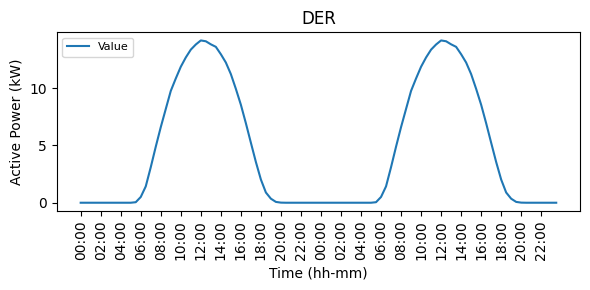

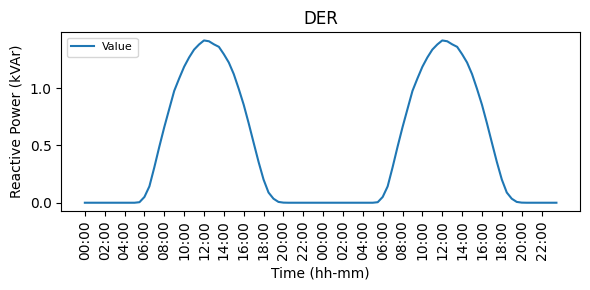

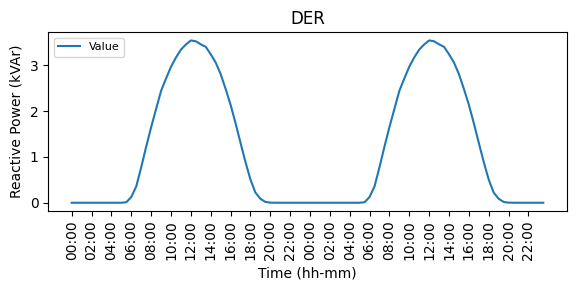

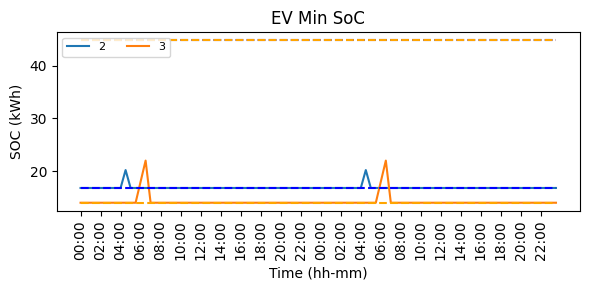

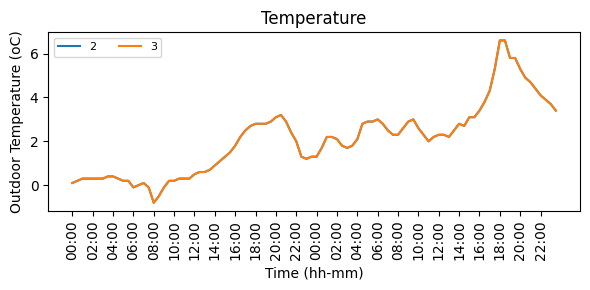

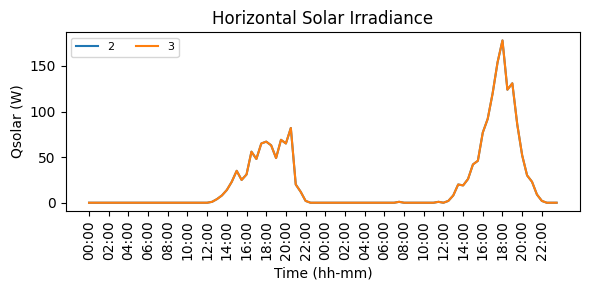

In [35]:
manager.plot_fun.param_plot(manager.parameter_df.Load_P*manager.anc_Vars.S_Base*1000, "Active Power Basic Load", 'Time (hh-mm)', 'Active Power (kW)')
manager.plot_fun.param_plot(manager.parameter_df.Load_Q*manager.anc_Vars.S_Base*1000, "Reactive Power Basic Load", 'Time (hh-mm)', 'Reactive Power (kVAr)')
manager.plot_fun.sum_param_plot(manager.parameter_df.Load_P*manager.anc_Vars.S_Base*1000,"Active Power Total Basic Load", "Time (hh-mm)" ,"Power (kW)")
manager.plot_fun.sum_param_plot(manager.parameter_df.Load_Q*manager.anc_Vars.S_Base*1000, "Reactive Power Total Basic Load", "Time (hh-mm)" ,"Power (kVAr)")
manager.plot_fun.param_plot(manager.parameter_df.unctrl_PV_gen_P*manager.anc_Vars.S_Base*1000, "DER", 'Time (hh-mm)', 'Active Power (kW)')
manager.plot_fun.param_plot(manager.parameter_df.ctrl_PV_gen_P*manager.anc_Vars.S_Base*1000, "DER", 'Time (hh-mm)', 'Active Power (kW)')
manager.plot_fun.param_plot(manager.parameter_df.unctrl_PV_gen_Q*manager.anc_Vars.S_Base*1000, "DER", 'Time (hh-mm)', 'Reactive Power (kVAr)')
manager.plot_fun.param_plot(manager.parameter_df.ctrl_PV_gen_Q*manager.anc_Vars.S_Base*1000, "DER", 'Time (hh-mm)', 'Reactive Power (kVAr)')
manager.plot_fun.param_plot(manager.parameter_df.EV_SoC_min_overtime_param*manager.anc_Vars.S_Base*1000, "EV Min SoC", 'Time (hh-mm)',  'SOC (kWh)')
y_value_min_4 = manager.model.EV_SoC_min_param[2]() * manager.anc_Vars.S_Base * 1000
y_value_max_4 = manager.model.EV_SoC_max_param[2]() * manager.anc_Vars.S_Base * 1000
y_value_min_6 = manager.model.EV_SoC_min_param[3]() * manager.anc_Vars.S_Base * 1000
y_value_max_6 = manager.model.EV_SoC_max_param[3]() * manager.anc_Vars.S_Base * 1000
plt.plot(range(96), np.full(96, y_value_min_4), color='blue', linestyle='--', )  # Horizontal dashed line
plt.plot(range(96), np.full(96, y_value_min_6), color='orange', linestyle='--', )  # Horizontal dashed line
plt.plot(range(96), np.full(96, y_value_max_4), color='blue', linestyle='--', )  # Horizontal dashed line
plt.plot(range(96), np.full(96, y_value_max_6), color='orange', linestyle='--')  # Horizontal dashed line
manager.plot_fun.param_plot(manager.parameter_df.Tout_param, "Temperature", 'Time (hh-mm)', 'Outdoor Temperature (oC)')
manager.plot_fun.param_plot(manager.parameter_df.Qsolar_param, "Horizontal Solar Irradiance", 'Time (hh-mm)',  'Qsolar (W)')


In [36]:
############################---------------------- Define Variables ---------------------############################

# In this test case as most of the functions will be used. Therefore both downward and upward and operation scenarios are modeled. 

###################### Downward Activation Scenario ########################
manager.initialize_voltage_variables(voltage_name_prefix="v_d", angle_name_prefix="pa_d")
manager.add_variable(variable_name_prefix="pgrid_d", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="qgrid_d", variable_set=manager.model.SGrid)
manager.initialize_der_variables(power_control_name_prefix="pder_contr_d", power_curtail_prefix="pder_curtail_contr_d", reactive_prefix_name="qder_contr_d")
manager.initialize_line_variables(line_set=manager.model.Slines, line_curr_name_prefix="Line_curr_d", line_rea_curr_name_prefix="Line_rea_curr_d", line_act_curr_name_prefix="Line_act_curr_d", line_losses_name_prefix="Line_losses_d")

###################### Upward Activation Scenario ########################
manager.initialize_voltage_variables("v_u", "pa_u")
manager.add_variable(variable_name_prefix="pgrid_u", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="qgrid_u", variable_set=manager.model.SGrid)
manager.initialize_der_variables(power_control_name_prefix="pder_contr_u", power_curtail_prefix="pder_curtail_contr_u", reactive_prefix_name="qder_contr_u")
manager.initialize_line_variables(line_set=manager.model.Slines, line_curr_name_prefix="Line_curr_u", line_rea_curr_name_prefix="Line_rea_curr_u", line_act_curr_name_prefix="Line_act_curr_u", line_losses_name_prefix="Line_losses_u")

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_variables("v", "pa")
manager.add_variable(variable_name_prefix="pgrid", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="qgrid", variable_set=manager.model.SGrid)
manager.initialize_der_variables(power_control_name_prefix="pder_contr", power_curtail_prefix="pder_curtail_contr", reactive_prefix_name="qder_contr")
manager.initialize_line_variables(line_set=manager.model.Slines, line_curr_name_prefix="Line_curr", line_rea_curr_name_prefix="Line_rea_curr", line_act_curr_name_prefix="Line_act_curr", line_losses_name_prefix="Line_losses")

# The reference bus must be defined manually.
ref_bus=0 
for t in manager.model.STimes:
    manager.model.v_d[ref_bus, t].fix(1)
    manager.model.pa_d[ref_bus, t].fix(0)

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v_u[ref_bus, t].fix(1)
    manager.model.pa_u[ref_bus, t].fix(0)

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)
    manager.model.pa[ref_bus, t].fix(0)

###################### EV Variables ########################

manager.initialize_ev_variables(pch_name_prefix="pEVch",q_name_prefix="qEV", soc_name_prefix="EVsoc")
manager.add_variable(variable_name_prefix="ev_ch_dp", variable_set=manager.model.SEVbuses)
manager.initialize_ev_flexibility_variables(pup_flex_ev_name_prefix="pup_flex_ev", pdown_flex_ev_name_prefix="pdown_flex_ev")

###################### HP and Building Variables ########################

manager.initialize_hp_variables(p_name_prefix="p_hp", q_name_prefix="q_hp")
manager.initialize_building_variables(model_type="3R2C", Qhp_name_prefix="Q_thermal", Tin_name_prefix="T_in", Te_name_prefix="T_e", min_temp_preference_param=manager.model.min_temp_preference_param , max_temp_preference_param=manager.model.max_temp_preference_param)

print(manager.list_variables())

['v_d', 'pa_d', 'pgrid_d', 'qgrid_d', 'pder_contr_d', 'pder_curtail_contr_d', 'qder_contr_d', 'Line_curr_d', 'Line_rea_curr_d', 'Line_act_curr_d', 'Line_losses_d', 'v_u', 'pa_u', 'pgrid_u', 'qgrid_u', 'pder_contr_u', 'pder_curtail_contr_u', 'qder_contr_u', 'Line_curr_u', 'Line_rea_curr_u', 'Line_act_curr_u', 'Line_losses_u', 'v', 'pa', 'pgrid', 'qgrid', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_rea_curr', 'Line_act_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc', 'ev_ch_dp', 'pup_flex_ev', 'pdown_flex_ev', 'p_hp', 'q_hp', 'Q_thermal', 'T_in', 'T_e']


In [37]:
###################----------------- Line Flow constraints ------------#######################

manager.add_real_current_flow_constraint(current_flow_constr_name_prefix="real_line_up_flow", active_curr_var=manager.model.Line_act_curr_u, voltage_var=manager.model.v_u, phase_angle_var=manager.model.pa_u)
manager.add_reactive_current_flow_constraint(reactive_flow_constr_name_prefix="reactive_line_up_flow", reactive_curr_var=manager.model.Line_rea_curr_u, voltage_var=manager.model.v_u, phase_angle_var=manager.model.pa_u)
manager.add_twoport_amplitude_constraint(name_prefix="line_flow_up", x_var=manager.model.Line_rea_curr_u, y_var=manager.model.Line_act_curr_u, amp_var=manager.model.Line_curr_u,  model_set=manager.model.Slines)

manager.add_real_current_flow_constraint(current_flow_constr_name_prefix="real_line_down_flow", active_curr_var=manager.model.Line_act_curr_d, voltage_var=manager.model.v_d, phase_angle_var=manager.model.pa_d)
manager.add_reactive_current_flow_constraint(reactive_flow_constr_name_prefix="reactive_line_down_flow", reactive_curr_var=manager.model.Line_rea_curr_d, voltage_var=manager.model.v_d, phase_angle_var=manager.model.pa_d)
manager.add_twoport_amplitude_constraint(name_prefix="line_flow_down", x_var=manager.model.Line_rea_curr_d, y_var=manager.model.Line_act_curr_d, amp_var=manager.model.Line_curr_d,  model_set=manager.model.Slines)

manager.add_real_current_flow_constraint(current_flow_constr_name_prefix="real_line_flow", active_curr_var=manager.model.Line_act_curr, voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
manager.add_reactive_current_flow_constraint(reactive_flow_constr_name_prefix="reactive_line_flow", reactive_curr_var=manager.model.Line_rea_curr, voltage_var=manager.model.v, phase_angle_var=manager.model.pa)
manager.add_twoport_amplitude_constraint(name_prefix="line_flow", x_var=manager.model.Line_rea_curr, y_var=manager.model.Line_act_curr, amp_var=manager.model.Line_curr,  model_set=manager.model.Slines)
manager.add_line_flow_losses_constraint(manager.model.Line_curr,  "line_losses")

###################----------------- Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule_up(model, i, time):
    return (model.pder_curtail_contr_u[i,time] ==  model.pder_curtail_contr_u[i,  time].ub - model.pder_contr_u[i,  time])
manager.model.Curtail_DER_cons_up = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule_up)  # Minimum, Maximum power for Gen

def Curtail_DER_Power_rule_down(model, i, time):
    return (model.pder_curtail_contr_d[i,time] ==  model.pder_curtail_contr_d[i,  time].ub - model.pder_contr_d[i,  time])
manager.model.Curtail_DER_cons_down = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule_down)  # Minimum, Maximum power for Gen

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen


In [38]:
print(manager.list_constraints())
manager.show_constraints("line_flow_up")
manager.show_constraints('line_losses')

['real_line_up_flow', 'reactive_line_up_flow', 'line_flow_up', 'real_line_down_flow', 'reactive_line_down_flow', 'line_flow_down', 'real_line_flow', 'reactive_line_flow', 'line_flow', 'line_losses']
line_flow_up[(1, 2, 0)]: Line_rea_curr_u[1,2,0]**2 + Line_act_curr_u[1,2,0]**2  ==  Line_curr_u[1,2,0]**2
line_flow_up[(1, 2, 1)]: Line_rea_curr_u[1,2,1]**2 + Line_act_curr_u[1,2,1]**2  ==  Line_curr_u[1,2,1]**2
line_flow_up[(1, 2, 2)]: Line_rea_curr_u[1,2,2]**2 + Line_act_curr_u[1,2,2]**2  ==  Line_curr_u[1,2,2]**2
line_flow_up[(1, 2, 3)]: Line_rea_curr_u[1,2,3]**2 + Line_act_curr_u[1,2,3]**2  ==  Line_curr_u[1,2,3]**2
line_flow_up[(1, 2, 4)]: Line_rea_curr_u[1,2,4]**2 + Line_act_curr_u[1,2,4]**2  ==  Line_curr_u[1,2,4]**2
line_flow_up[(1, 2, 5)]: Line_rea_curr_u[1,2,5]**2 + Line_act_curr_u[1,2,5]**2  ==  Line_curr_u[1,2,5]**2
line_flow_up[(1, 2, 6)]: Line_rea_curr_u[1,2,6]**2 + Line_act_curr_u[1,2,6]**2  ==  Line_curr_u[1,2,6]**2
line_flow_up[(1, 2, 7)]: Line_rea_curr_u[1,2,7]**2 + Line_a

In [39]:
####################-------------------- EV Constrain -----------------------#######################
manager.add_ev_soc_constraint(name_prefix="EV_SOC_cons")
manager.add_power_ch_dp_ev_cons(name_prefix="power_ch_dp_ev_cons")

# #################### EV minimum SoC before departure ################ 
manager.add_ev_min_departure_soc_constraint(name_prefix="EV_min_departure_SOC_cons")

# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=manager.model.pup_flex_ev, model_ev_flex_down=manager.model.pdown_flex_ev)

# ###################### Upward Flexibility Constraints ########################
manager.add_power_up_flex_ev_cons(name_prefix="power_up_flex_ev_cons")
manager.add_power_up_flex_max_cons(name_prefix="power_up_max_cons")

# ###################### Downward Flexibility Constraints ########################
manager.add_power_down_flex_min_cons(name_prefix="power_down_flex_ev_cons")
manager.add_power_down_flex_ev_cons(name_prefix="power_down_min_cons")

####################-------------------- HP Constrain -----------------------#######################
manager.add_building_thermodynamic_constraint(Tin = manager.model.T_in, Te=manager.model.T_e, Qhp=manager.model.Q_thermal, Tout=manager.model.Tout_param,  
                                              Qsol= manager.model.Qsolar_param, Q_dynamic_prefix_name="Q_hp_dynamic_constraint", Te_dynamic_prefix_name="T_e_dynamic_constraint")
manager.add_HP_operation_constraint(Tout_param=manager.model.Tout_param, Qhp=manager.model.Q_thermal, php=manager.model.p_hp,qhp=manager.model.q_hp, php_operation_prefix_name="active_power_hp_operation_constraint", qhp_operation_prefix_name="reactive_power_hp_operation_constraint")

In [40]:
print(manager.list_constraints())
manager.show_constraints("EV_min_departure_SOC_cons")
manager.show_constraints("power_up_flex_ev_cons")

['real_line_up_flow', 'reactive_line_up_flow', 'line_flow_up', 'real_line_down_flow', 'reactive_line_down_flow', 'line_flow_down', 'real_line_flow', 'reactive_line_flow', 'line_flow', 'line_losses', 'EV_SOC_cons', 'power_ch_dp_ev_cons', 'EV_min_departure_SOC_cons', 'power_up_flex_ev_cons', 'power_up_max_cons', 'power_down_flex_ev_cons', 'power_down_min_cons', 'Q_hp_dynamic_constraint', 'T_e_dynamic_constraint', 'active_power_hp_operation_constraint', 'reactive_power_hp_operation_constraint']
EV_min_departure_SOC_cons[(2, 0)]: EV_SoC_min_overtime_param[2,0]  <=  EVsoc[2,0]
EV_min_departure_SOC_cons[(2, 1)]: EV_SoC_min_overtime_param[2,1]  <=  EVsoc[2,1]
EV_min_departure_SOC_cons[(2, 2)]: EV_SoC_min_overtime_param[2,2]  <=  EVsoc[2,2]
EV_min_departure_SOC_cons[(2, 3)]: EV_SoC_min_overtime_param[2,3]  <=  EVsoc[2,3]
EV_min_departure_SOC_cons[(2, 4)]: EV_SoC_min_overtime_param[2,4]  <=  EVsoc[2,4]
EV_min_departure_SOC_cons[(2, 5)]: EV_SoC_min_overtime_param[2,5]  <=  EVsoc[2,5]
EV_min_depa

In [41]:
manager.add_active_power_flex_flow_constraint(manager.model.pder_contr_u, manager.model.pgrid_u, manager.model.pEVch, manager.model.pup_flex_ev, manager.model.v_u, manager.model.pa_u, "active_power_up_flow", "upward", manager.model.p_hp)
manager.add_reactive_power_flex_flow_constraint(manager.model.qder_contr_u, manager.model.qgrid_u, manager.model.qEV, manager.model.v_u, manager.model.pa_u, "reactive_power_up_flow", manager.model.q_hp)

manager.add_active_power_flex_flow_constraint(manager.model.pder_contr_d, manager.model.pgrid_d, manager.model.pEVch, manager.model.pdown_flex_ev, manager.model.v_d, manager.model.pa_d, "active_power_down_flow", "downward", manager.model.p_hp)
manager.add_reactive_power_flex_flow_constraint(manager.model.qder_contr_d, manager.model.qgrid_d, manager.model.qEV, manager.model.v_d, manager.model.pa_d, "reactive_power_down_flow", manager.model.q_hp)

manager.add_active_power_flow_constraint(manager.model.pder_contr, manager.model.pgrid, manager.model.pEVch, manager.model.v, manager.model.pa, "active_power_flow", manager.model.p_hp)
manager.add_reactive_power_flow_constraint(manager.model.qder_contr, manager.model.qgrid, manager.model.qEV, manager.model.v, manager.model.pa, "reactive_power_flow", manager.model.q_hp)


In [42]:
#objective function
def obj_rule(model,k):
    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    return (0
            - sum(model.pup_flex_ev[k, time] for time in model.STimes for k in model.SEVbuses) 
            - sum(model.pdown_flex_ev[k, time] for time in model.STimes for k in model.SEVbuses) 
            + curtail_term)
manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [43]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-10       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
# solver.options['acceptable_tol'] = 1e-4            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-10
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    23934
Number of nonzeros in inequality constraint Jacobian.:     1388
Number of nonzeros in Lagrangian Hessian.............:     6624

Total number of variables............................:     6834
                     variables with only lower bounds:      586
                variables with lower and upper bounds:     4138
                     variables with only upper bounds:        0
Total number of equality constraints..

In [44]:
manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

['EVsoc', 'Line_act_curr', 'Line_act_curr_d', 'Line_act_curr_u', 'Line_curr', 'Line_curr_d', 'Line_curr_u', 'Line_losses', 'Line_losses_d', 'Line_losses_u', 'Line_rea_curr', 'Line_rea_curr_d', 'Line_rea_curr_u', 'Q_thermal', 'T_e', 'T_in', 'ev_ch_dp', 'pEVch', 'p_hp', 'pa', 'pa_d', 'pa_u', 'pder_contr', 'pder_contr_d', 'pder_contr_u', 'pder_curtail_contr', 'pder_curtail_contr_d', 'pder_curtail_contr_u', 'pdown_flex_ev', 'pgrid', 'pgrid_d', 'pgrid_u', 'pup_flex_ev', 'qEV', 'q_hp', 'qder_contr', 'qder_contr_d', 'qder_contr_u', 'qgrid', 'qgrid_d', 'qgrid_u', 'v', 'v_d', 'v_u']
          2         3
0  0.020000  0.031059
1  0.022023  0.031335
2  0.023532  0.031617
3  0.024781  0.031904
4  0.025878  0.032196


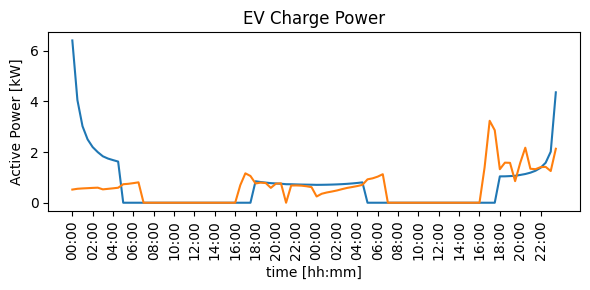

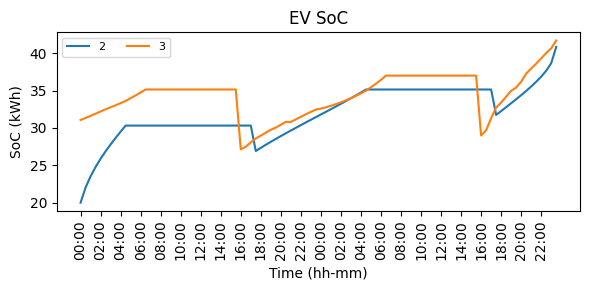

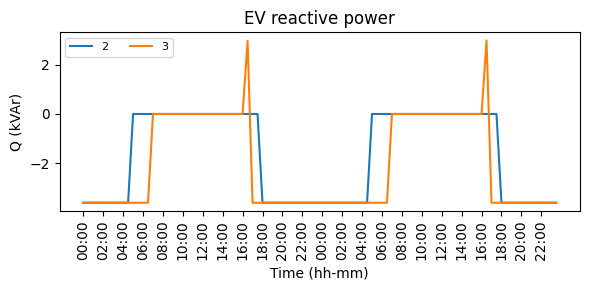

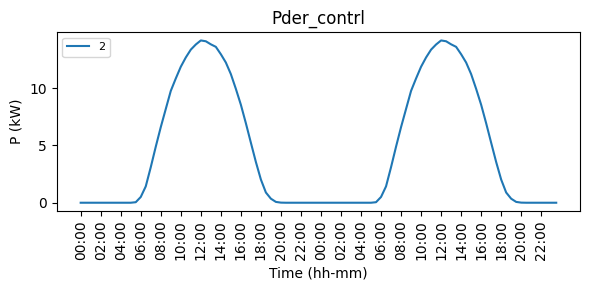

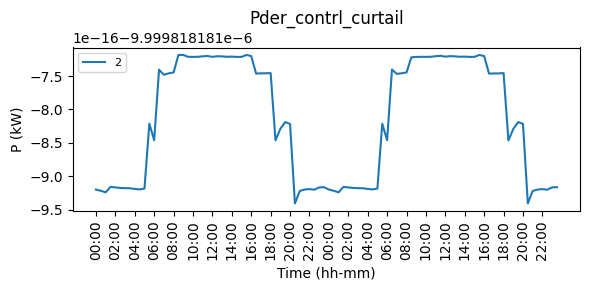

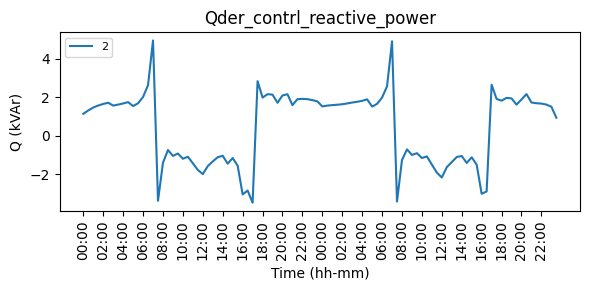

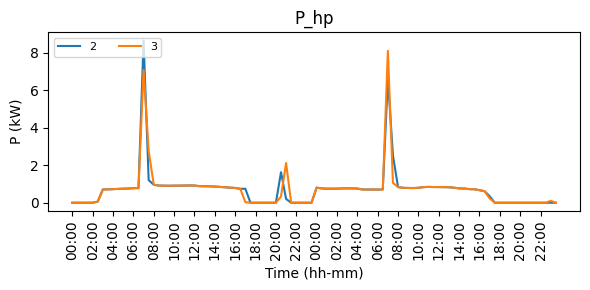

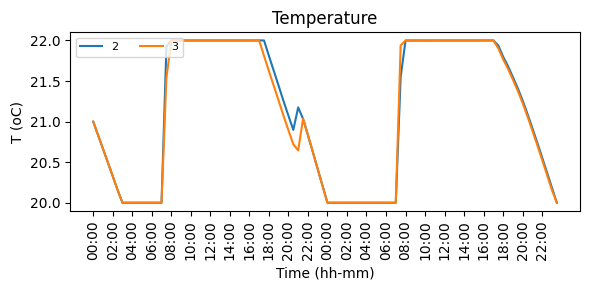

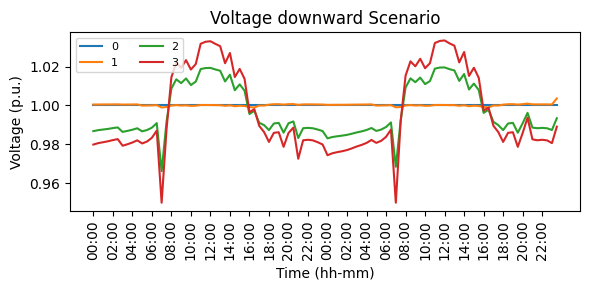

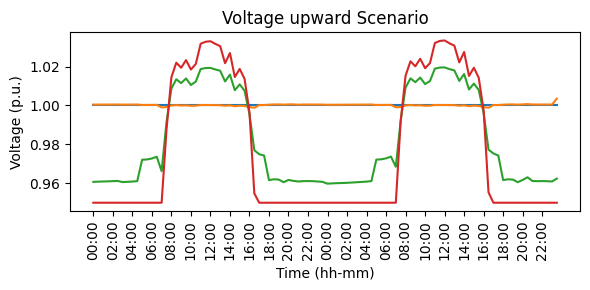

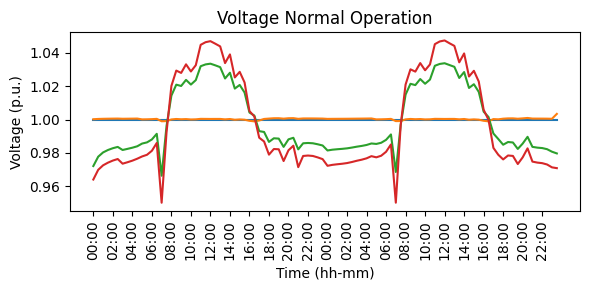

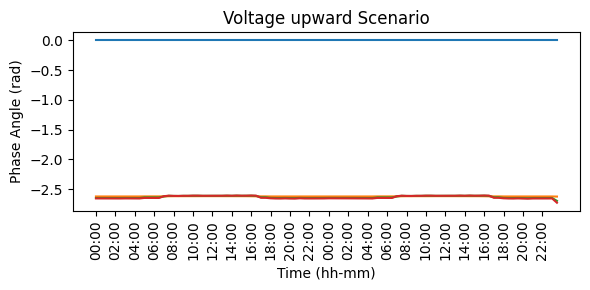

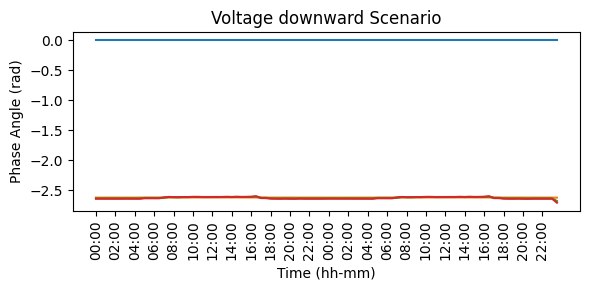

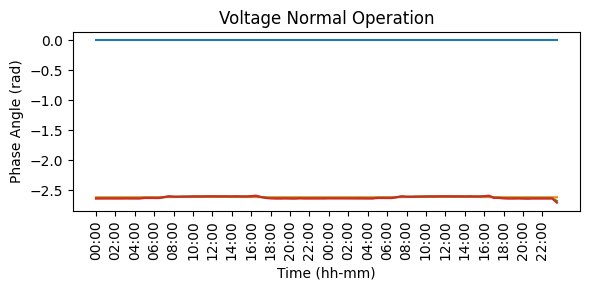

In [45]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.p_hp*manager.anc_Vars.S_Base*1000,"P_hp", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.T_in,"Temperature", "Time (hh-mm)" ,"T (oC)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.v_d,"Voltage downward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
manager.plot_fun.result_df_plot(manager.results.v_u,"Voltage upward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v,"Voltage Normal Operation", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.pa_u,"Voltage upward Scenario", "Time (hh-mm)" ,"Phase Angle (rad)")
manager.plot_fun.result_df_plot(manager.results.pa_d,"Voltage downward Scenario", "Time (hh-mm)" ,"Phase Angle (rad)")
manager.plot_fun.result_df_plot(manager.results.pa,"Voltage Normal Operation", "Time (hh-mm)" ,"Phase Angle (rad)")


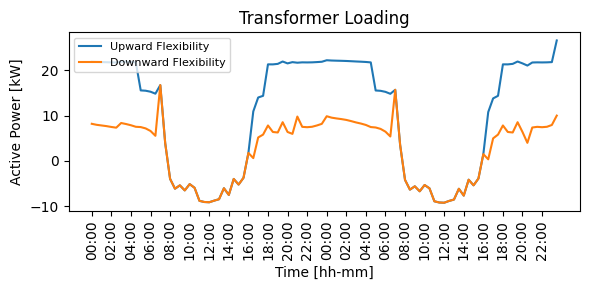

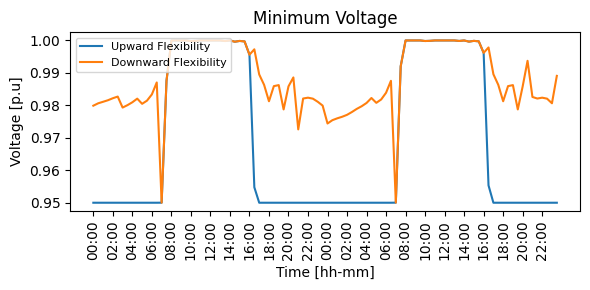

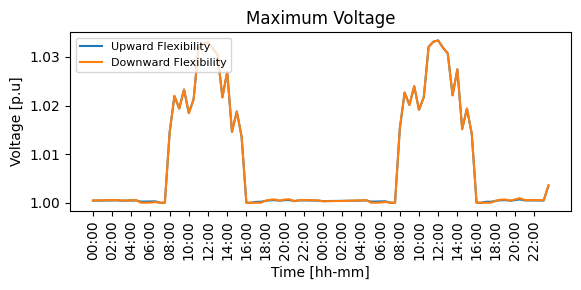

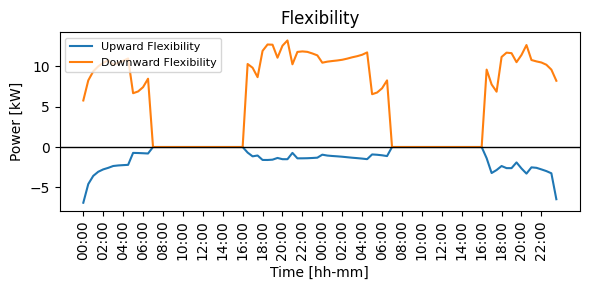

In [46]:
manager.results_flexibility_plot(manager.results.pgrid_u*manager.anc_Vars.S_Base*1000,manager.results.pgrid_d*manager.anc_Vars.S_Base*1000,"Transformer Loading", "Time [hh-mm]", "Active Power [kW]")
manager.results_flexibility_plot(manager.results.v_u.min(axis=1),manager.results.v_d.min(axis=1),"Minimum Voltage", "Time [hh-mm]", "Voltage [p.u]")
manager.results_flexibility_plot(manager.results.v_u.max(axis=1),manager.results.v_d.max(axis=1),"Maximum Voltage", "Time [hh-mm]", "Voltage [p.u]")
manager.results_flexibility_plot(manager.results.pdown_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*-1000,manager.results.pup_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*1000,"Flexibility", "Time [hh-mm]", "Power [kW]", zero_axes="yes", shading="Yes")
